In [3]:
import utility
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

from utility import get_all_stats
plt.rcParams['text.usetex'] = True
# mpl.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'serif'  # Use Computer Modern fonts
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts}'


# Define color palette
palette = list(sns.color_palette("Set2")[:3])

# Define the custom orders

FORCE_FIELD_ORDER = ['espaloma-0.3.1', 'gaff-2.11', 'openff-2.0.0']
FF_NAME = {
    'espaloma-0.3.1': 'Espaloma', 
    'gaff-2.11': 'GAFF',
    'openff-2.0.0': 'OpenFF',
}
SYSTEM_NAME = {
    "mbar": "FEP",
    "dh-gb": "MMGBSA",
    # "dg-c2-gb": "MMGBSA-C2",
    # "dg-ie-gb": "MMGBSA-IE",
    # "dh-pb": "MMPBSA",
    # "dg-c2-pb": "MMPBSA-C2",
    # "dg-ie-pb": "MMPBSA-IE",
}
SYSTEM_ORDER = SYSTEM_NAME.keys()


def kendall_correlation(x, y):
    """
    Compute Kendall's tau correlation between two 1D arrays or lists.

    Parameters:
    -----------
    x, y : array-like
        Input vectors. Must have the same length.

    Returns:
    --------
    tau : float
        Kendall's tau correlation coefficient.
    p_value : float
        Two-sided p-value for a hypothesis test whose null hypothesis is that 
        two sets of data are independent.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    if x.shape[0] != y.shape[0]:
        raise ValueError("Input vectors must have the same length.")
    
    tau, p_value = kendalltau(x, y)
    return tau

def pair_significance_test(func, obs, A, B, N_boot=10_000):
    obs = np.array(obs)
    A = np.array(A)
    B = np.array(B)
    # Bootstrap the difference distribution
    funcsA = np.empty(N_boot)
    funcsB = np.empty(N_boot)
    for i in range(N_boot):
        idx = np.random.randint(0, len(obs), len(obs))  # sample indices with replacement
        funcsA[i] = func(obs[idx], A[idx])
        funcsB[i] = func(obs[idx], B[idx])
    # deltas = np.sort(funcsA - funcsB)
    # tail = (1 - confidence / 100) / 2
    # # Summary statistics
    # # ci95 = np.percentile(deltas, [2.5, 97.5])
    # # To be consistent with previous calculations
    # ci95 = (deltas[int(tail * N_boot)], deltas[int((1 - tail) * N_boot)])
    deltas = funcsA - funcsB
    p_two_sided = 2 * min(np.mean(deltas <= 0), np.mean(deltas >= 0))
    return p_two_sided

def to_latex(string):
    try:
        return r"$\mathrm{" + string.replace("_", r"\_").replace("-", r"-").replace(" ", r"\ ") + r"}$"
    except:
        raise Exception(string)

def plot_stats(ax, data, contribution='spearman', legend = 'auto'):
    dat2work = data.copy()
    
    SYSTEM_ORDER_LATEX = [to_latex(SYSTEM_NAME[s]) for s in SYSTEM_ORDER]
    FORCE_FIELD_ORDER_LATEX = [to_latex(FF_NAME[f]) for f in FORCE_FIELD_ORDER]
    
    values = dat2work[contribution].apply(utility.get_numerical_values)
    values = np.array(list(values.values))
    
    ci_low = []
    ci_high = []
    nominal_value = []
    for v, l, h in values:
        if v:
            nominal_value.append(v)
            ci_low.append(v - l)
            ci_high.append(h - v)
        else:
            nominal_value.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)

    dat2work['ci_low'] = ci_low
    dat2work['ci_high'] = ci_high
    dat2work[contribution] = nominal_value
    
    # dat2work['ci_low'] = values[:,0] - values[:,1]
    # dat2work['ci_high'] = values[:,2] - values[:,0]
    # dat2work['value'] = values[:,0]

    
    dat2work['source'] = pd.Categorical(
        dat2work['source'].replace(SYSTEM_NAME).map(to_latex), categories=SYSTEM_ORDER_LATEX, ordered=True
    )
    dat2work['force_field'] = pd.Categorical(
        dat2work['force_field'].replace(FF_NAME).map(to_latex), categories=FORCE_FIELD_ORDER_LATEX, ordered=True
    )

    # Sort the DataFrame based on the custom orders
    dat2work = dat2work.sort_values(by=['source', 'force_field']).reset_index(drop=True)

    bar_plot = sns.barplot(
        data=dat2work,
        x="source",
        y=contribution,
        hue='force_field',
        width=0.5,
        ax=ax,
        legend=legend,
        hue_order=FORCE_FIELD_ORDER_LATEX,
        palette=palette,
        order=SYSTEM_ORDER_LATEX
    )

    # Add labels to bars
    for patch in bar_plot.patches:
        # Extract the bar height (value) and x, y coordinates
        bar_height = patch.get_height()
        bar_width = patch.get_width()
        bar_x = patch.get_x() + bar_width / 2
        bar_y = bar_height
        
        # Add a label only if the bar height is not zero
        if bar_height > 0:
            ax.text(
                bar_x, bar_y / 2,  # Coordinates for text
                rf'${bar_height:.2f}$',  # Format the label value
                ha='center', va='center', fontsize=19, color='white', weight='bold')#, rotation=90)

    # Those are the patch used on the legend and attached at the end
    num_unique_ff = len(dat2work["force_field"].unique())
    # [:-num_unique_ff] ensures that only the patches of the real bars are considered
    if legend:
        bar_positions = sorted([patch.get_x() + patch.get_width() / 2 for patch in bar_plot.patches[:-num_unique_ff]])
    else:
        bar_positions = sorted([patch.get_x() + patch.get_width() / 2 for patch in bar_plot.patches])
    dat2work.dropna(inplace=True)
    ax.errorbar(
        x=bar_positions,  # Position of the bar
        y=dat2work[contribution],
        yerr=[dat2work['ci_low'], dat2work['ci_high']],
        fmt='none',  # No marker
        c='gray',
        capsize=5
    )

    if contribution == 'pearson':
        ax.set(
            ylabel=r'$\rho$'
        )
    elif contribution == 'spearman':
        ax.set(
            ylabel=r'$r_S$'
        )
    elif contribution == 'kendall':
        ax.set(
            ylabel=r'$\tau$'
        )
    elif contribution == 'mue':
        ax.set(
            ylabel=r'$\mathrm{ocMUE}$'
        )
        
    ax.set(xlabel='')
    ax.tick_params(axis='x', rotation=90)

def significance_matrix_plot(ax, matrix, sim_columns):
    # Labels for axes
    labels = []
    for col in sim_columns:
        _, calc_type, ff = col.split("_")
        labels.append(f"{SYSTEM_NAME[calc_type]}/{FF_NAME[ff]}")

    # Create a background color array: 1 for empty, 0 for arrows
    bg_colors = np.zeros_like(matrix, dtype=float)
    for i in range(len(labels)):
        for j in range(len(labels)):
            if matrix[i, j] in [r"$\downarrow$", r"$\leftarrow$"]:
                bg_colors[i, j] = 1  # mark as colored
                # bg_colors[i, j] = 0  # mark as colored
            elif matrix[i, j] in [r"$=$"]:
                bg_colors[i, j] = 2  # mark as colored
                # bg_colors[i, j] = 0  # mark as colored
            else:
                bg_colors[i, j] = 0  # leave white


    sns.heatmap(bg_colors,
                fmt="",
                cmap=["whitesmoke", "palegreen", "aliceblue"],# palegreen, whitesmoke
                # cmap=["white"],
                annot=matrix,
                cbar=False,
                square=True,  # <--- enforce square cells
                linewidths=0.05,
                linecolor="gray",
                ax=ax)
    # # After plotting, recolor the arrow annotations
    # for text in ax.texts:  # loop through all annotations
    #     if text.get_text() in [r"$\downarrow$", r"$\leftarrow$"]:
    #         text.set_color("green")  # make arrows green
    #     else:
    #         text.set_color("black")  # everything else black
    
    # Force LaTeX rendering for tick labels
    ax.set_xticklabels([rf"$\mathrm{{{l}}}$" for l in labels], rotation=90, fontsize=15)
    ax.set_yticklabels([rf"$\mathrm{{{l}}}$" for l in labels], rotation=0, fontsize=15)


In [4]:
BindFlowData = pd.read_csv("../data/simulation/bindflow/gather/BindFlow.csv", index_col=0)
mean = BindFlowData.groupby(["system", "ligand"]).mean().reset_index().drop(columns=["replica", "sample"])
mask = mean["simulation_mbar_espaloma-0.3.1"].notna()
mean = mean[mask]
# Filter column names
cols_to_keep = [col for col in mean.columns 
                if (col.startswith('simulation_') 
                and any(x in col for x in ['openff', 'gaff', 'espaloma']))
                or any(x == col for x in ['ligand', 'system', 'exp_dG'])
                ]
    
filtered_df = mean[cols_to_keep]


In [5]:
# Filter the df
sim_columns = []
for calc_type in SYSTEM_ORDER:
    for ff in FORCE_FIELD_ORDER:
        sim_columns.append(f"simulation_{calc_type}_{ff}")
    


df_mse_removed = filtered_df.copy()[["system", "ligand"] + sim_columns + ["exp_dG"]]
# Remove the nan values because of the sampl6-oa system
df_mse_removed.dropna(inplace=True)
# All analysis will be done without the outlier
df_mse_removed = df_mse_removed[~((df_mse_removed["system"] == "thrombin") & (df_mse_removed["ligand"] == "lig_4"))]
for system in filtered_df["system"].unique():
    for col in sim_columns:
        mse = (df_mse_removed.loc[df_mse_removed["system"] == system,col] - df_mse_removed.loc[df_mse_removed["system"] == system,"exp_dG"]).mean()
        df_mse_removed.loc[df_mse_removed["system"] == system,col] -= mse
df_mse_removed = df_mse_removed.drop(columns=['system', 'ligand'])

In [6]:
matrix_mue = np.full((len(sim_columns), len(sim_columns)), "", dtype='<U20')
for j in range(len(sim_columns)):
    for i in range(len(sim_columns)):
        if j < i:
            p_two_sided_value = pair_significance_test(
                func=utility.mue,
                obs=df_mse_removed["exp_dG"],
                A=df_mse_removed[sim_columns[i]],
                B=df_mse_removed[sim_columns[j]],
                N_boot=10_000
            )
            # Use alpha = 0.05
            if p_two_sided_value < 0.05:
                # Significant difference
                A_mue = utility.mue(df_mse_removed["exp_dG"], df_mse_removed[sim_columns[i]])
                B_mue = utility.mue(df_mse_removed["exp_dG"], df_mse_removed[sim_columns[j]])
                if A_mue < B_mue:
                    matrix_mue[i, j] = r"$\leftarrow$"
                else:
                    matrix_mue[i, j] = r"$\downarrow$"
            else:
                matrix_mue[i, j] = r"$=$"
        elif j > i:
            if matrix_mue[j, i] == r"$\leftarrow$":
                matrix_mue[i, j] = r"$\downarrow$"
            elif matrix_mue[j, i] == r"$\downarrow$":
                matrix_mue[i, j] = r"$\leftarrow$"
            elif matrix_mue[j, i] == r"$=$":
                matrix_mue[i, j] = r"$=$"
matrix_mue

array([['', '$=$', '$=$', '$\\leftarrow$', '$\\leftarrow$',
        '$\\leftarrow$'],
       ['$=$', '', '$=$', '$\\leftarrow$', '$\\leftarrow$',
        '$\\leftarrow$'],
       ['$=$', '$=$', '', '$\\leftarrow$', '$\\leftarrow$',
        '$\\leftarrow$'],
       ['$\\downarrow$', '$\\downarrow$', '$\\downarrow$', '',
        '$\\downarrow$', '$=$'],
       ['$\\downarrow$', '$\\downarrow$', '$\\downarrow$',
        '$\\leftarrow$', '', '$\\leftarrow$'],
       ['$\\downarrow$', '$\\downarrow$', '$\\downarrow$', '$=$',
        '$\\downarrow$', '']], dtype='<U20')

In [7]:
matrix_kendall = np.full((len(sim_columns), len(sim_columns)), "", dtype='<U20')
for j in range(len(sim_columns)):
    for i in range(len(sim_columns)):
        if j < i:
            p_two_sided_value = pair_significance_test(
                func=kendall_correlation,
                obs=df_mse_removed["exp_dG"],
                A=df_mse_removed[sim_columns[i]],
                B=df_mse_removed[sim_columns[j]],
                N_boot=10_000
            )
            # Use alpha = 0.05
            if p_two_sided_value < 0.05:
                # Significant difference
                A_kendall = kendall_correlation(df_mse_removed["exp_dG"], df_mse_removed[sim_columns[i]])
                B_kendall = kendall_correlation(df_mse_removed["exp_dG"], df_mse_removed[sim_columns[j]])
                print((i, j), A_kendall, B_kendall)
                if A_kendall > B_kendall:
                    matrix_kendall[i, j] = r"$\leftarrow$"
                else:
                    matrix_kendall[i, j] = r"$\downarrow$"
            else:
                matrix_kendall[i, j] = r"$=$"
        elif j > i:
            if matrix_kendall[j, i] == r"$\leftarrow$":
                matrix_kendall[i, j] = r"$\downarrow$"
            elif matrix_kendall[j, i] == r"$\downarrow$":
                matrix_kendall[i, j] = r"$\leftarrow$"
            elif matrix_kendall[j, i] == r"$=$":
                matrix_kendall[i, j] = r"$=$"
matrix_kendall

(3, 1) 0.39117707968796855 0.5568243964400468
(4, 1) 0.4321183199079424 0.5568243964400468
(5, 1) 0.4111771108299098 0.5568243964400468
(3, 2) 0.39117707968796855 0.5556479240199326
(4, 2) 0.4321183199079424 0.5556479240199326
(5, 2) 0.4111771108299098 0.5556479240199326


array([['', '$=$', '$=$', '$=$', '$=$', '$=$'],
       ['$=$', '', '$=$', '$\\leftarrow$', '$\\leftarrow$',
        '$\\leftarrow$'],
       ['$=$', '$=$', '', '$\\leftarrow$', '$\\leftarrow$',
        '$\\leftarrow$'],
       ['$=$', '$\\downarrow$', '$\\downarrow$', '', '$=$', '$=$'],
       ['$=$', '$\\downarrow$', '$\\downarrow$', '$=$', '', '$=$'],
       ['$=$', '$\\downarrow$', '$\\downarrow$', '$=$', '$=$', '']],
      dtype='<U20')

In [8]:
stats_data = get_all_stats(df_mse_removed, replicates=10_000, confidence=68)
stats_data["ff"] = stats_data.index

stats_data["source"] = stats_data.index.str.split("_").str[1]
stats_data["force_field"] = stats_data.index.str.split("_").str[-1]
stats_data.reset_index(inplace=True)
stats_data

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


,index,pearson,kendall,spearman,rmse,mse,mue,ff,source,force_field
0,simulation_mbar_espaloma-0.3.1,"0.72 [68%: 0.67, 0.77]","0.49 [68%: 0.44, 0.54]","0.66 [68%: 0.61, 0.72]","1.84 [68%: 1.72, 1.95]","-0.0 [68%: -0.16, 0.16]","1.43 [68%: 1.33, 1.53]",simulation_mbar_espaloma-0.3.1,mbar,espaloma-0.3.1
1,simulation_mbar_gaff-2.11,"0.76 [68%: 0.71, 0.79]","0.56 [68%: 0.52, 0.60]","0.75 [68%: 0.70, 0.78]","1.59 [68%: 1.47, 1.69]","-0.0 [68%: -0.14, 0.14]","1.23 [68%: 1.14, 1.32]",simulation_mbar_gaff-2.11,mbar,gaff-2.11
2,simulation_mbar_openff-2.0.0,"0.77 [68%: 0.73, 0.80]","0.56 [68%: 0.52, 0.59]","0.76 [68%: 0.71, 0.79]","1.63 [68%: 1.52, 1.73]","0.0 [68%: -0.15, 0.14]","1.26 [68%: 1.17, 1.35]",simulation_mbar_openff-2.0.0,mbar,openff-2.0.0
3,simulation_dh-gb_espaloma-0.3.1,"0.58 [68%: 0.50, 0.65]","0.39 [68%: 0.34, 0.44]","0.54 [68%: 0.47, 0.61]","5.62 [68%: 5.09, 6.1]","-0.0 [68%: -0.48, 0.48]","3.99 [68%: 3.65, 4.34]",simulation_dh-gb_espaloma-0.3.1,dh-gb,espaloma-0.3.1
4,simulation_dh-gb_gaff-2.11,"0.59 [68%: 0.50, 0.66]","0.43 [68%: 0.38, 0.48]","0.59 [68%: 0.53, 0.65]","4.79 [68%: 4.27, 5.26]","0.0 [68%: -0.41, 0.42]","3.39 [68%: 3.11, 3.68]",simulation_dh-gb_gaff-2.11,dh-gb,gaff-2.11
5,simulation_dh-gb_openff-2.0.0,"0.60 [68%: 0.52, 0.67]","0.41 [68%: 0.36, 0.46]","0.56 [68%: 0.49, 0.62]","5.37 [68%: 4.85, 5.83]","-0.0 [68%: -0.46, 0.47]","3.82 [68%: 3.5, 4.15]",simulation_dh-gb_openff-2.0.0,dh-gb,openff-2.0.0


In [9]:
# split into FEP and MMGBSA, only plot for now MBAR and MMGBSA
filter_stats_data = stats_data[stats_data["source"].isin(SYSTEM_ORDER)]
filter_stats_data
# Get stat plot for kendall and MSE on [0,1] and [0,1] and on [1,0] and [1,1] the significance.

,index,pearson,kendall,spearman,rmse,mse,mue,ff,source,force_field
0,simulation_mbar_espaloma-0.3.1,"0.72 [68%: 0.67, 0.77]","0.49 [68%: 0.44, 0.54]","0.66 [68%: 0.61, 0.72]","1.84 [68%: 1.72, 1.95]","-0.0 [68%: -0.16, 0.16]","1.43 [68%: 1.33, 1.53]",simulation_mbar_espaloma-0.3.1,mbar,espaloma-0.3.1
1,simulation_mbar_gaff-2.11,"0.76 [68%: 0.71, 0.79]","0.56 [68%: 0.52, 0.60]","0.75 [68%: 0.70, 0.78]","1.59 [68%: 1.47, 1.69]","-0.0 [68%: -0.14, 0.14]","1.23 [68%: 1.14, 1.32]",simulation_mbar_gaff-2.11,mbar,gaff-2.11
2,simulation_mbar_openff-2.0.0,"0.77 [68%: 0.73, 0.80]","0.56 [68%: 0.52, 0.59]","0.76 [68%: 0.71, 0.79]","1.63 [68%: 1.52, 1.73]","0.0 [68%: -0.15, 0.14]","1.26 [68%: 1.17, 1.35]",simulation_mbar_openff-2.0.0,mbar,openff-2.0.0
3,simulation_dh-gb_espaloma-0.3.1,"0.58 [68%: 0.50, 0.65]","0.39 [68%: 0.34, 0.44]","0.54 [68%: 0.47, 0.61]","5.62 [68%: 5.09, 6.1]","-0.0 [68%: -0.48, 0.48]","3.99 [68%: 3.65, 4.34]",simulation_dh-gb_espaloma-0.3.1,dh-gb,espaloma-0.3.1
4,simulation_dh-gb_gaff-2.11,"0.59 [68%: 0.50, 0.66]","0.43 [68%: 0.38, 0.48]","0.59 [68%: 0.53, 0.65]","4.79 [68%: 4.27, 5.26]","0.0 [68%: -0.41, 0.42]","3.39 [68%: 3.11, 3.68]",simulation_dh-gb_gaff-2.11,dh-gb,gaff-2.11
5,simulation_dh-gb_openff-2.0.0,"0.60 [68%: 0.52, 0.67]","0.41 [68%: 0.36, 0.46]","0.56 [68%: 0.49, 0.62]","5.37 [68%: 4.85, 5.83]","-0.0 [68%: -0.46, 0.47]","3.82 [68%: 3.5, 4.15]",simulation_dh-gb_openff-2.0.0,dh-gb,openff-2.0.0


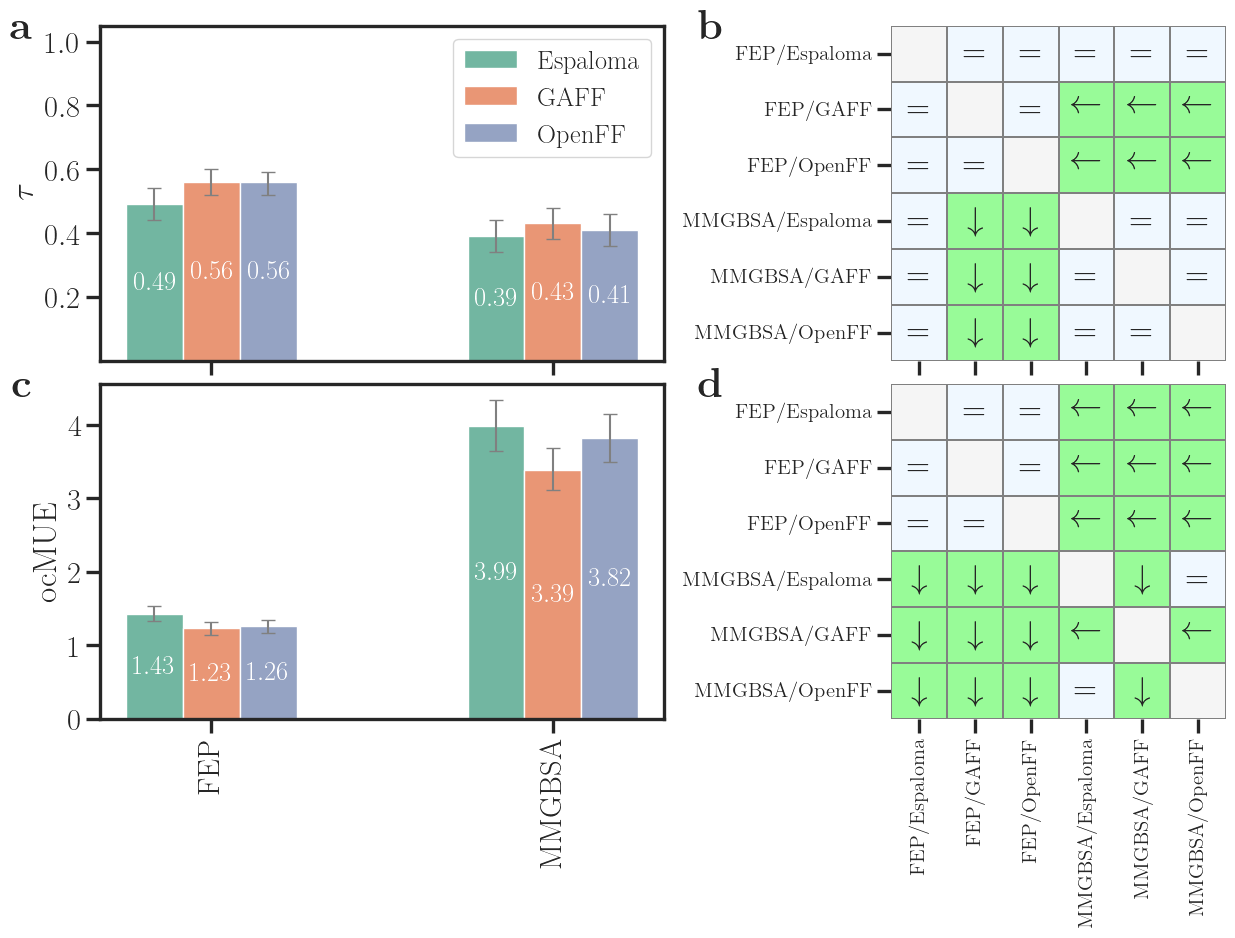

In [10]:
scale = 2  
sns.set_theme(
    style="ticks", 
    font_scale=scale,
    rc={
        "axes.linewidth": 1.2 * scale,
        # "lines.linewidth": 1.1 * scale
        }
)

# Make ticks thicker/longer in proportion to font scaling
plt.rcParams.update({
    "xtick.major.size": 5 * scale,   # length of major ticks
    "ytick.major.size": 5 * scale,
    "xtick.major.width": 1.2 * scale,  # thickness of major ticks
    "ytick.major.width": 1.2 * scale,
})
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 9), sharex='col')

plot_stats(ax=axs[0,0],data=filter_stats_data, contribution='kendall', legend="auto")

plot_stats(ax=axs[1,0],data=filter_stats_data, contribution='mue', legend=None)


axs[0,0].set(ylim=[0,1.05])
axs[0,0].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])

significance_matrix_plot(
    ax=axs[0,1],
    matrix=matrix_kendall,
    sim_columns=sim_columns
)
significance_matrix_plot(
    ax=axs[1,1],
    matrix=matrix_mue,
    sim_columns=sim_columns
)

axs[0,0].get_legend().set_title(None)
axs[0,0].legend(ncol=1, loc='best', fontsize=19)  # Adjust legend position if needed

# Add subplot labels
labels = ['a', 'b', 'c', 'd']
for ax, label in zip(axs.flat, labels):
    if label in ['b', 'd']:
        x_position = -0.5
    else:
        x_position = -0.12
    
    ax.text(x_position, 1.05, f"$\\mathbf{{{label}}}$", transform=ax.transAxes, 
            fontsize=30, va='top', ha='right')
    
fig.subplots_adjust(wspace=0.2, hspace=0.07)

fig.savefig('summary/stats/global-significance.pdf',
            bbox_inches="tight",
            pad_inches=0.05,
            transparent=False)

# Create the diagonal matrix
